# SE/2015/026

# S. PRASANTH

## PREDICT AND GIVE QUANTITATIVE SCORE FOR COVID-19 USING CHEST CT IMAGES

In [1]:
# pip install pydicom

In [2]:
import pydicom #For working with DICOM files
import os #For operating system dependend functionality
import pandas as pd #Data analysis and manipulation tool
import numpy as np #Package for linear algebra and multidimentional arrays
import tensorflow as tf #Deep learning tool
import cv2 #Image processing library

from sklearn.model_selection import train_test_split #For split the dataset into trained and test dataset
from sklearn.metrics import f1_score #F1 score
from sklearn.metrics import confusion_matrix #Confusion matrix

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import inspect
from tqdm import tqdm

import tensorflow.keras.backend as K #Transfer learning

#Build model
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

#GRAD-CAM
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import argparse
import imutils

## LOAD CSV DATA

In [3]:
#Load Trained Meta Dataset
trainedMetaData = pd.read_csv('../Dataset/CSV/CT Trained Metadata.csv', index_col=1)

trainedMetaData.head()

,Id,Dataset_type,Result,Image_Names
Label,,,,
ARDS,0,TRAIN,0,ARDS (1).jpg
ARDS,1,TRAIN,0,ARDS (2).jpg
COVID-19,2,TRAIN,1,Covid-19 (1).jpeg
COVID-19,3,TRAIN,1,Covid-19 (2).jpeg
COVID-19,4,TRAIN,1,Covid-19 (3).jpeg


In [4]:
#Trained dataset count
len(trainedMetaData)

5354

In [5]:
#Load Test Meta Dataset
testMetaData = pd.read_csv('../Dataset/CSV/CT Test Metadata.csv', index_col=1)

testMetaData.head()

,Id,Dataset_type,Image_Names
Label,,,
COVID-19,5377,TEST,Covid-19 (106).jpg
COVID-19,5378,TEST,Covid-19 (107).jpg
COVID-19,5379,TEST,Covid-19 (108).jpg
COVID-19,5380,TEST,Covid-19 (109).jpg
COVID-19,5381,TEST,Covid-19 (110).jpg


In [6]:
#Test dataset count
len(testMetaData)

599

## DATA PRE-PROCESSING

In [7]:
#Check for Null Values in Trained Meta Dataset
trainedMetaData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5354 entries, ARDS to Streptococcus
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            5354 non-null   int64 
 1   Dataset_type  5354 non-null   object
 2   Result        5354 non-null   int64 
 3   Image_Names   5354 non-null   object
dtypes: int64(2), object(2)
memory usage: 209.1+ KB


In [8]:
#Check for Data duplications in Trained Meta Dataset
trainedMetaData.duplicated().sum()

0

In [9]:
#Check for Null Values in Test Meta Dataset
testMetaData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 599 entries, COVID-19 to SARS
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            599 non-null    int64 
 1   Dataset_type  599 non-null    object
 2   Image_Names   599 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.7+ KB


In [10]:
#Check for Data duplications in Test Meta Dataset
trainedMetaData.duplicated().sum()

0

In [11]:
#Summary of Whole Meta Dataset
metaSummaryData = pd.read_csv('../Dataset/CSV/CT Metadata Summary.csv', index_col=1)

metaSummaryData.head(8)

,Label
Image_Count,
117,COVID-19
1576,Normal
2,ARDS
2773,Pnemonia Bacteria
1469,Pnemonia Virus
11,SARS
5,Streptococcus
5953,Total


## DISPLAY CT IMAGE

In [12]:
#Function to display Image
def ShowCTImage(titleNoise, titleNoiseRemoval, image):
    image_noise = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_denoise = cv2.GaussianBlur(image, (5, 5), 0)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (12, 10))
    
    ax1.imshow(image_noise, cmap = 'gray')
    ax2.imshow(img_denoise, cmap = 'gray')
    
    ax1.set_title(titleNoise)
    ax1.grid(False)
    
    ax2.set_title(titleNoiseRemoval)
    ax2.grid(False)

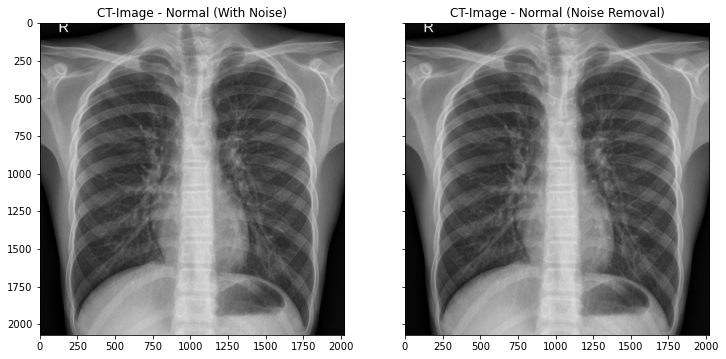

In [13]:
#Call diplay Healthy Patient's Chest CT Image
fileName = "../Dataset/CT/TRAIN/Normal (33).jpeg"
image = cv2.imread(fileName)
ShowCTImage("CT-Image - Normal (With Noise)", "CT-Image - Normal (Noise Removal)", image)

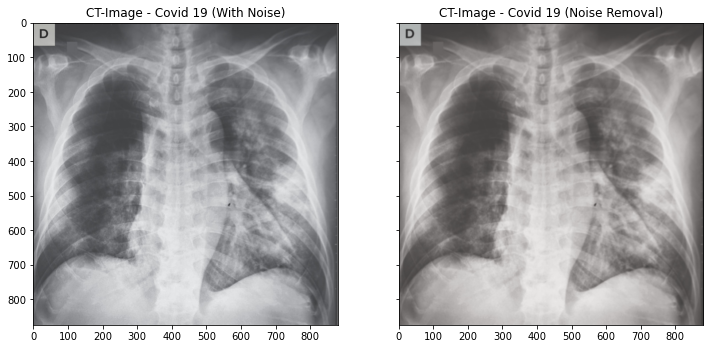

In [14]:
#Call diplay Covid-19 Patient's Chest CT Image
fileName = "../Dataset/CT/TRAIN/Covid-19 (5).jpeg"
image = cv2.imread(fileName)
ShowCTImage("CT-Image - Covid 19 (With Noise)", "CT-Image - Covid 19 (Noise Removal)", image)

## LOAD IMAGES

In [15]:
trainedImageArray = []
imageSize = 224
testImageArray = []

#Load and resize trained images
for i in range(len(trainedMetaData)):
    imgPath = "../Dataset/CT/TRAIN/" + trainedMetaData['Image_Names'][i] #Image path
    
    img = cv2.imread(imgPath) #Read image
    imgArray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert image color to RGB
    newImgArray = cv2.resize(imgArray, (imageSize, imageSize)) #Resize image
    
    trainedImageArray.append([newImgArray, trainedMetaData['Result'][i]]) #Load trained images into an array

In [16]:
#Total trained imageset
print(len(trainedImageArray))

5354


In [17]:
#Load and resize test images
for i in range(len(testMetaData)):
    imgPath = "../Dataset/CT/TEST/" + testMetaData['Image_Names'][i] #Image path
    
    img = cv2.imread(imgPath) #Read image
    imgArray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert image color to RGB
    newImgArray = cv2.resize(imgArray, (imageSize, imageSize)) #Resize image
    
    testImageArray.append(newImgArray) #Load trained images into an array

In [18]:
#Total test imageset
print(len(testImageArray))

599


In [19]:
#Suffle trained images
np.random.shuffle(trainedImageArray)

x = []
y = []

for image in trainedImageArray:
    x.append(image[0])
    y.append(image[1])

#Convert x and y to numpy array
x = np.array(x)
y = np.array(y)

In [20]:
#Compare Covid-19 and Non Covid-19 trained data count
print(pd.Series(y).value_counts())

0    5249
1     105
dtype: int64


In [21]:
#Function to display random images
def PrintRandomSamples():
    index_0 = []
    index_1 = []

    for i, v in enumerate(y):
      if v == 1:
        index_1.append(i)
      else:
        index_0.append(i)

    plot_index_0 = np.random.choice(index_0)
    plot_index_1 = np.random.choice(index_1)

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,10))

    ax1.imshow(x[plot_index_0],cmap = 'gray')
    ax2.imshow(x[plot_index_1],cmap = 'gray')

    ax1.set_title(y[plot_index_0])
    ax2.set_title(y[plot_index_1])

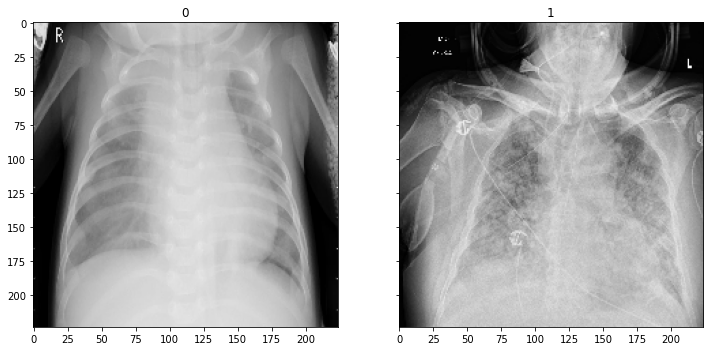

In [22]:
#Validate print random images
PrintRandomSamples()

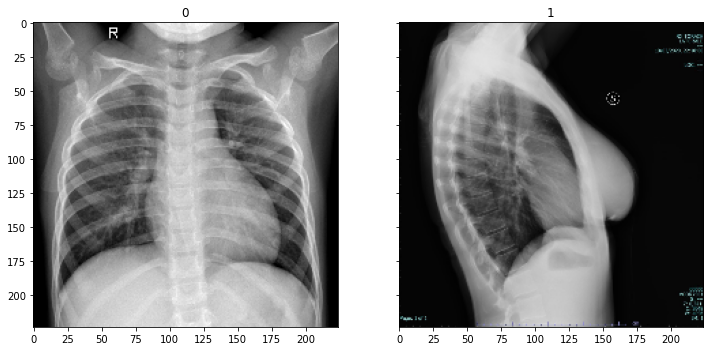

In [23]:
#Validate print random images
PrintRandomSamples()

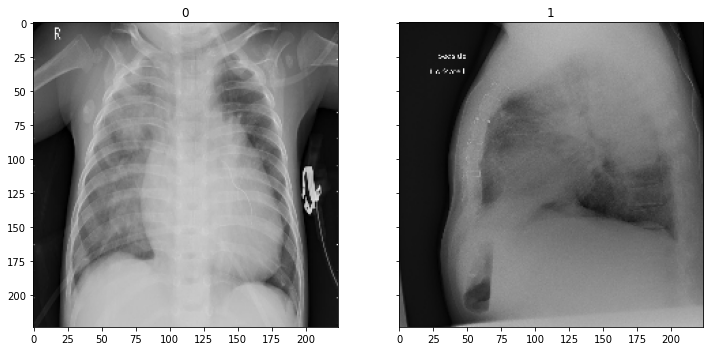

In [24]:
#Validate print random images
PrintRandomSamples()

## TRAIN-TEST SPLIT

In [25]:
#Train-Test split
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

In [26]:
testImageArray = np.array(testImageArray)

testImageArray = testImageArray / 255

print(X_train.shape, X_val.shape, testImageArray.shape)

(4283, 224, 224, 3) (1071, 224, 224, 3) (599, 224, 224, 3)


In [27]:
#Return y_val counts of unique values
pd.Series(y_val).value_counts(normalize = True)

0    0.980392
1    0.019608
dtype: float64

In [28]:
#Return y_train counts of unique values
pd.Series(y_train).value_counts(normalize = True)

0    0.980388
1    0.019612
dtype: float64

In [29]:
print(X_train.shape, X_val.shape)

(4283, 224, 224, 3) (1071, 224, 224, 3)


## KERAS PROCESSING

In [30]:
def get_f1(yTrue, yPred):
    truePositives = K.sum(K.round(K.clip(yTrue * yPred, 0, 1)))
    possiblePositives = K.sum(K.round(K.clip(yTrue, 0, 1)))
    predictedPositives = K.sum(K.round(K.clip(yPred, 0, 1)))
    
    precision = truePositives / (predictedPositives + K.epsilon())
    recall = truePositives / (possiblePositives + K.epsilon())
    
    f1Val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1Val

In [31]:
conv_base = VGG16(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

In [32]:
train_layers = [layer.name for layer in conv_base.layers[::-1][:5]]

train_layers

['block5_pool', 'block5_conv3', 'block5_conv2', 'block5_conv1', 'block4_pool']

In [33]:
batchSize = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255.0)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255.0)

train_generator = train_datagen.flow(X_train, y_train, batch_size = batchSize)

val_generator = val_datagen.flow(X_val, y_val, batch_size = batchSize)

## BUILD MODEL

In [49]:
def buildModel():
    model = tf.keras.models.Sequential()

    model.add(conv_base)

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

    for layer in conv_base.layers:
        if layer.name in train_layers:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), loss = 'binary_crossentropy', metrics = [get_f1])
    
    return model

In [50]:
model = buildModel()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 27,560,769
Trainable params: 19,925,505
Non-trainable params: 7,635,264
_________________________________________________________________


## TRAIN MODEL

In [51]:
stepsPerEpoch = len(X_train) // batchSize
epochs = 30
validationSteps = 22

In [52]:
model.fit(
    train_generator, 
    steps_per_epoch = stepsPerEpoch, 
    epochs = epochs, 
    validation_data = val_generator, 
    validation_steps = validationSteps, 
    class_weight = {0:1, 1:2}
)

Epoch 1/30
133/133 [==============================] - 1615s 12s/step - loss: 0.0643 - get_f1: 0.2232 - val_loss: 0.0207 - val_get_f1: 0.4545
Epoch 2/30
133/133 [==============================] - 1515s 11s/step - loss: 0.0218 - get_f1: 0.4138 - val_loss: 0.0306 - val_get_f1: 0.4833
Epoch 3/30
133/133 [==============================] - 1625s 12s/step - loss: 0.0140 - get_f1: 0.4381 - val_loss: 0.0073 - val_get_f1: 0.4545
Epoch 4/30
133/133 [==============================] - 1603s 12s/step - loss: 0.0110 - get_f1: 0.4657 - val_loss: 0.0234 - val_get_f1: 0.3606
Epoch 5/30
133/133 [==============================] - 1722s 13s/step - loss: 0.0089 - get_f1: 0.4421 - val_loss: 0.0055 - val_get_f1: 0.5000
Epoch 6/30
133/133 [==============================] - 1746s 13s/step - loss: 0.0069 - get_f1: 0.4080 - val_loss: 0.0099 - val_get_f1: 0.4303
Epoch 7/30
133/133 [==============================] - 1598s 12s/step - loss: 0.0037 - get_f1: 0.4261 - val_loss: 0.0139 - val_get_f1: 0.5303
Epoch 8/30
13

### EVALUATE VALIDATION DATA

In [57]:
preds = model.predict(X_val / 255.0)
predictions = []

In [58]:
for i in preds:
    if i > 0.5:
        predictions.append(1)
    else :
        predictions.append(0)
        
fScore = f1_score(y_val, predictions)

print(fScore)

0.9302325581395349


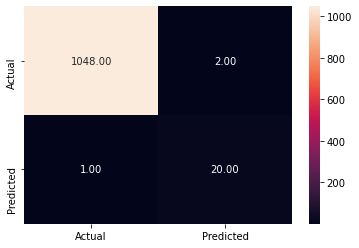

In [59]:
#Confusion Matrix
conMatrix = confusion_matrix(y_val, predictions)
sns.heatmap(conMatrix, annot = True, fmt = '.2f', xticklabels = ['Actual', 'Predicted'], yticklabels = ['Actual', 'Predicted'])

## PREDICT TEST DATA

In [60]:
preds = model.predict(testImageArray)
predictions = []

In [61]:
for i in preds:
    if i[0] > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

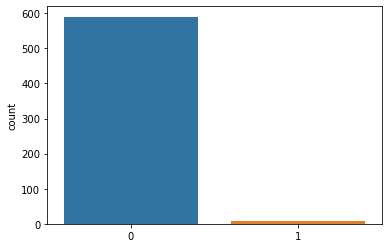

In [62]:
sns.countplot(predictions)

In [63]:
result = pd.DataFrame(predictions, columns = ['prediction'])

result.to_csv('../Dataset/CSV/Predicted_Results.csv', index=False)

In [66]:
result['prediction'].value_counts()

0    590
1      9
Name: prediction, dtype: int64